## Imports

In [2]:
import numpy as np
import netsquid as ns

from netsquid.qubits.ketstates import s0
from netsquid.qubits.state_sampler import StateSampler
from netsquid.qubits.qformalism import QFormalism
from netsquid.nodes.connections import DirectConnection
from netsquid.components.qprocessor import QuantumProcessor
from netsquid.components.qsource import QSource, SourceStatus
from netsquid.components.qchannel import QuantumChannel
from netsquid.nodes.node import Node
from netsquid.components.instructions import IGate
from netsquid.components import T1T2NoiseModel, FibreDelayModel

from n_node_RB import MultiNodeRB
from teleportationnoisemodel import TeleportationNoiseModel

import pickle as pk
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import t

## Multi node simulation

In [25]:
t1_time     = 1e9       
t2_time     = 12e6      
gate_time   = 39e3      
alpha       = 0.95
min_bounces = 1
max_bounces = 20
n_samples   = 40
node_counts = [2, 3, 4, 5, 6]
ns.set_qstate_formalism(QFormalism.DM)
for n_nodes in node_counts:
    ns.sim_reset()
    nodes = [Node(f"Node{i}") for i in range(n_nodes)]
    proc0 = QuantumProcessor("QPD0", num_positions=2, mem_noise_models=[T1T2NoiseModel(T1=t1_time, T2=t2_time)] * 2)
    nodes[0].qmemory = proc0
    for i in range(1, n_nodes):
        proc = QuantumProcessor(f"QPD{i}", num_positions=1, mem_noise_models=[T1T2NoiseModel(T1=t1_time, T2=t2_time)])
        nodes[i].qmemory = proc
    sampler = StateSampler([s0], probabilities=[1.0])
    source  = QSource("QSource", state_sampler=sampler, status=SourceStatus.EXTERNAL)
    nodes[0].add_subcomponent(source)
    for i in range(n_nodes - 1):
        ch_up = QuantumChannel(f"TelChannel{i}{i+1}", length=40, models={"delay_model":    FibreDelayModel(), "quantum_noise_model": TeleportationNoiseModel(alpha=alpha)})
        ch_dn = QuantumChannel(f"TelChannel{i+1}{i}", length=40, models={"delay_model":    FibreDelayModel(), "quantum_noise_model": TeleportationNoiseModel(alpha=alpha)})
        conn = DirectConnection(f"Conn{i}{i+1}", ch_up, ch_dn)
        nodes[i].connect_to(nodes[i+1], conn, label=f"quantum{i}{i+1}")
    rb = MultiNodeRB(nodes=nodes, min_bounces=min_bounces, max_bounces=max_bounces, n_samples=n_samples)
    for instr in rb.cliffords:
        for node in nodes:
            node.qmemory.add_instruction(instr, duration=gate_time, topology=[0], q_noise_model=T1T2NoiseModel(T1=t1_time, T2=t2_time))
    rb.start()
    ns.sim_run()
    mean_fids, all_seq_fids = rb.get_fidelity()
    data = {"decay_data": (mean_fids, all_seq_fids), "endpoints": [min_bounces, max_bounces]}
    with open(f"{n_nodes}_RB_decay.pickle", "wb") as f:
        pk.dump(data, f)

## Plotting


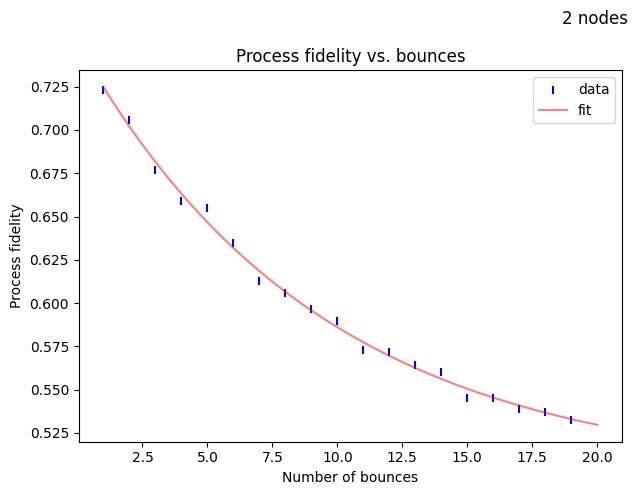

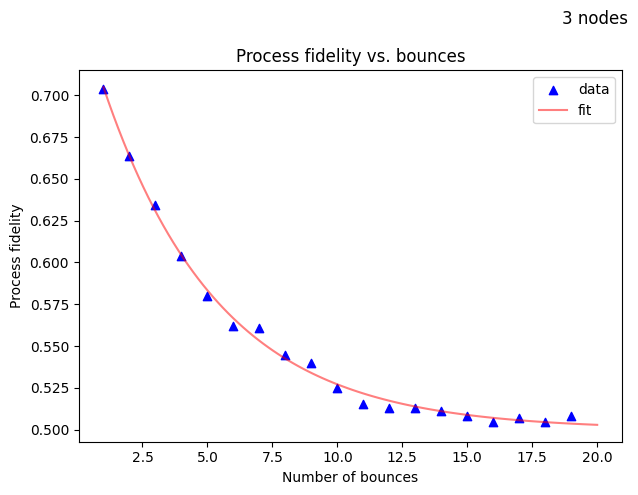

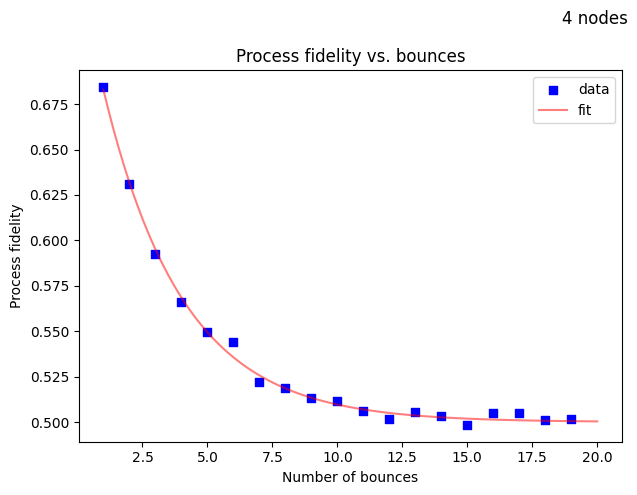

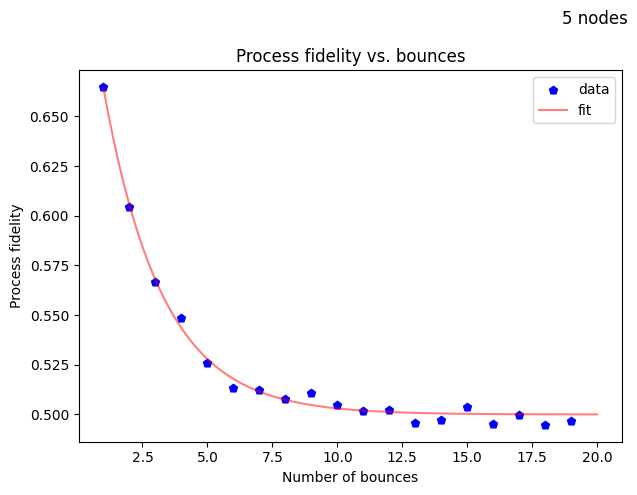

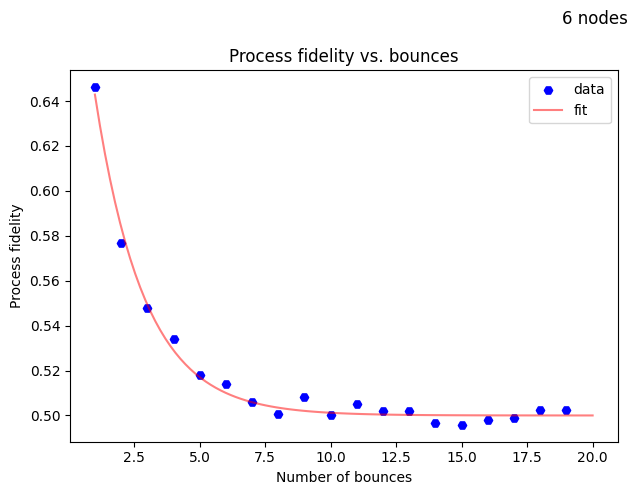

In [ ]:
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def exp(m, A, f):
    """Exponential fit used in the RB analysis."""
    return 0.5 * (1.0 + A * (f ** m))

# approximate time-per-hop constant (taken from gate_time in the simulation)
GATE_TIME = 39_000  # same units as your simulation (e.g., nanoseconds)

# list of node counts to analyse
n_nodes_list = [2, 3, 4, 5, 6]
symbols = {2: "|", 3: "^", 4: "s", 5: "p", 6: "H"}

for i in n_nodes_list:
    # load fidelity data for this number of nodes
    with open(f"{i}_RB_decay.pickle", "rb") as f:
        result = pk.load(f)

    # the bounce-length range (min_bounces, max_bounces)
    min_b, max_b = result["endpoints"]
    bounces = np.arange(min_b, max_b)
    # extract the mean fidelities for each bounce value
    mean_fids = [result["decay_data"][0][m] for m in bounces]
    process_fids = [(b + 1.0) / 2.0 for b in mean_fids]

    # fit an exponential to the fidelity data
    popt, pcov = curve_fit(exp, bounces, process_fids)

    # compute approximate times: number of hops × GATE_TIME
    times = []
    for m in bounces:
        path_length = (2 * i - 1) + (m - 1) * (2 * i - 2)
        times.append(path_length * GATE_TIME)

    # draw two subplots: fidelity vs. bounces and time vs. bounces
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{i} nodes")

    # (1) bounces vs. fidelity
    ax = plt.gca()                      # grab the current Axes
    ax.scatter(bounces, process_fids, marker=symbols[i], color="b", label="data")
    plt.subplot(1, 2, 1)
    plt.scatter(bounces, process_fids, marker=symbols[i], color="b", label="data")
    x_fit = np.linspace(min_b, max_b, 100)
    ax.set_xticks(np.arange(0, 21, 1))
    plt.plot(x_fit, exp(x_fit, *popt), alpha=0.5, color="r", label="fit")
    plt.xlabel("Number of bounces")
    plt.ylabel("Process fidelity")
    plt.title("Process fidelity vs. bounces")
    plt.legend()

    # (2) bounces vs. time
    # plt.subplot(1, 2, 2)
    # plt.plot(bounces, times, color="g")
    # plt.xlabel("Number of bounces")
    # plt.ylabel("Total time (arb. units)")
    # plt.title("Time vs. bounces")

    plt.tight_layout()
    plt.show()
